# Загрузка и очистка данных

In [1]:
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import scipy.stats as sps

In [2]:
df_train = pd.read_csv('main_task.csv')
# df_test = pd.read_csv('kaggle_task.csv')

## Посмотрим, что получили

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [3]:
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 23.7 MB


In [4]:
df_train.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


- В целевой переменной Rating пропусков нет
- В признаках Cuisine Style, Price Range, Number of Reviews есть пропуски
- Признаки Cuisine Style, Reviews надо разбирать на списки
- Признаки City, Price Range - категориальные
- Что делать с URL_TA пока неясно
- Признаки Restaurant_id и ID_TA считаем бесполезными для предсказания

## Готовим объединённый датасет

In [5]:
# делаем имена попроще
df_train.columns = ['Restaurant_id', 'City', 'Cuisine', 'Ranking', 'Rating', 'Price', 'nReviews', 'Reviews', 'URL_TA', 'ID_TA']

In [6]:
# дропаем лишнее
df = df_train.drop(columns=['Restaurant_id', 'URL_TA', 'ID_TA'])

## Чистим, заполняем и преобразуем данные

### Price Range

In [7]:
df['Price'].unique()

array(['$$ - $$$', nan, '$$$$', '$'], dtype=object)

In [8]:
# заменим на числа
price_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
df['Price'] = df['Price'].replace(to_replace=price_dict)
df['Price'].unique()

array([ 2., nan,  3.,  1.])

In [9]:
# отметим, где были пропуски
df['Price_WasNA'] = df['Price'].isna().astype('uint8')

In [10]:
# попробуем использовать стоимость, как дробную величину для заполнения пропусков
# заменим стоимость на среднюю по городу
price_by_city = df[['City', 'Price']].groupby(by='City').agg(['min', 'mean', 'max'])
price_by_city = price_by_city['Price']
# готовим столбец для замены Price на среднее по City
mean_price_values = {price_by_city.index[i]: price_by_city['mean'].values[i] for i in range(price_by_city.shape[0])}
df.loc[df['Price'].isna(), 'Price'] = df['City'].replace(to_replace=mean_price_values)

### City

In [11]:
df['City'].value_counts()

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64

In [12]:
# сделаем признак категориальным
df['City'] = df['City'].astype('category')

### Cuisine Style

In [13]:
# извлекает список значений из строки вида
# ['European', 'French', 'International']
def extract_list(s):
    if pd.notna(s):
        return list(filter(None, re.split("'(.*?)'[,\s]*", s.strip('[]'))))
    else:
        return []

In [14]:
df['Cuisine'] = df['Cuisine'].apply(extract_list)
df['Cuisine']

0                        [European, French, International]
1                                                       []
2        [Japanese, Sushi, Asian, Grill, Vegetarian Fri...
3                                                       []
4          [German, Central European, Vegetarian Friendly]
                               ...                        
39995    [Italian, Vegetarian Friendly, Vegan Options, ...
39996    [French, American, Bar, European, Vegetarian F...
39997                                    [Japanese, Sushi]
39998    [Polish, European, Eastern European, Central E...
39999                                            [Spanish]
Name: Cuisine, Length: 40000, dtype: object

In [15]:
# сколько всего видов кухни
print(df['Cuisine'].explode().nunique())
# и как называются
df['Cuisine'].explode().unique()
# слишком много, чтобы работать в лоб

125


array(['European', 'French', 'International', nan, 'Japanese', 'Sushi',
       'Asian', 'Grill', 'Vegetarian Friendly', 'Vegan Options',
       'Gluten Free Options', 'German', 'Central European', 'Italian',
       'Pizza', 'Fast Food', 'Mediterranean', 'Spanish', 'Healthy',
       'Cafe', 'Thai', 'Vietnamese', 'Bar', 'Pub', 'Chinese', 'British',
       'Polish', 'Fusion', 'Dutch', 'Mexican', 'Venezuelan',
       'South American', 'Soups', 'Belgian', 'Steakhouse', 'Latin',
       'Barbecue', 'Argentinean', 'Irish', 'Seafood', 'Swiss',
       'Portuguese', 'Contemporary', 'Wine Bar', 'Greek',
       'Central American', 'Indian', 'Middle Eastern', 'Turkish',
       'Hungarian', 'Pakistani', 'Peruvian', 'Delicatessen',
       'Eastern European', 'Swedish', 'Scandinavian', 'Tibetan', 'Nepali',
       'Korean', 'Southwestern', 'Czech', 'American', 'Slovenian',
       'Balti', 'Street Food', 'Diner', 'Brew Pub', 'Caribbean',
       'Austrian', 'Moroccan', 'Halal', 'Lebanese', 'Russian', 'Afr

In [16]:
# популярность видов кухонь
df['Cuisine'].explode().value_counts()
# есть очень редкие

Vegetarian Friendly    11189
European               10060
Mediterranean           6277
Italian                 5964
Vegan Options           4486
                       ...  
Salvadoran                 1
Latvian                    1
Xinjiang                   1
Yunnan                     1
Burmese                    1
Name: Cuisine, Length: 125, dtype: int64

In [17]:
# заполним пропуски отдельной меткой
df['Cuisine'] = df['Cuisine'].apply(lambda x: x if len(x)>0 else ['Unknown'])

### Reviews

In [18]:
# извлекает список списков из строки вида
# [['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]
def extract_list_in_list(s):
    if pd.notna(s):
        return list(filter(None, re.split("\[\[(.*)\],\s\[(.*)\]\]", s)))
    else:
        return []

In [19]:
df['Reviews'] = df['Reviews'].apply(extract_list_in_list)
df['ReviewsText'] = df['Reviews'].apply(lambda x: extract_list(x[0]) if x else [])
df['ReviewsDate'] = df['Reviews'].apply(lambda x: list(pd.to_datetime(extract_list(x[1]))) if x else [])
df.drop(columns='Reviews', inplace=True)

In [20]:
df[['ReviewsText', 'ReviewsDate']]

,ReviewsText,ReviewsDate
0,"[Good food at your doorstep, A good hotel rest...","[2017-12-31 00:00:00, 2017-11-20 00:00:00]"
1,"[Unique cuisine, Delicious Nepalese food]","[2017-07-06 00:00:00, 2016-06-19 00:00:00]"
2,"[Catch up with friends, Not exceptional]","[2018-01-08 00:00:00, 2018-01-06 00:00:00]"
3,[],[]
4,"[Best place to try a Bavarian food, Nice build...","[2017-11-18 00:00:00, 2017-02-19 00:00:00]"
...,...,...
39995,"[The real Italian experience!, Wonderful food,...","[2017-12-16 00:00:00, 2017-11-12 00:00:00]"
39996,"[Parisian atmosphere, Bit pricey but interesti...","[2017-12-21 00:00:00, 2017-12-12 00:00:00]"
39997,"[Good by swedish standards, A hidden jewel in ...","[2016-11-03 00:00:00, 2008-04-12 00:00:00]"
39998,"[Underground restaurant, Oldest Restaurant in ...","[2017-07-11 00:00:00, 2017-06-18 00:00:00]"


### Number of Reviews

In [21]:
# посмотрим какая картина с пропусками
df[df['nReviews'].isna()]

,City,Cuisine,Ranking,Rating,Price,nReviews,Price_WasNA,ReviewsText,ReviewsDate
8,Vienna,[Unknown],2692.0,4.0,1.853933,NaN,1,[],[]
21,Madrid,[Unknown],5847.0,4.0,1.849827,NaN,1,[],[]
32,Budapest,[Unknown],1328.0,5.0,1.710197,NaN,1,"[Absolutely amazing, tasty, fresh, cheap Ch...]",[2015-10-26 00:00:00]
102,Budapest,"[French, European, Hungarian]",1410.0,5.0,1.710197,NaN,1,[],[]
108,Prague,"[Italian, Mediterranean]",2050.0,5.0,2.000000,NaN,0,[],[]
...,...,...,...,...,...,...,...,...,...
39965,Rome,[Unknown],5722.0,5.0,1.723804,NaN,1,[],[]
39972,Prague,"[Cafe, Delicatessen, Healthy, Wine Bar, Street...",2012.0,5.0,1.000000,NaN,0,[Personal expirence],[2017-10-27 00:00:00]
39986,Madrid,[Unknown],7279.0,3.0,1.849827,NaN,1,[],[]
39988,Berlin,[Unknown],4970.0,4.0,1.754799,NaN,1,[],[]


In [22]:
# отметим, где были пропуски
df['nReviews_WasNA'] = df['nReviews'].isna().astype('uint8')

In [23]:
# заменим количество отзывов на медиану по городу
nReviews_by_city = df[['City', 'nReviews']].groupby(by='City').agg(['min', 'median', 'max'])
nReviews_by_city = nReviews_by_city['nReviews']
# готовим столбец для замены nReviews на среднее по City
mean_nReviews_values = {nReviews_by_city.index[i]: nReviews_by_city['median'].values[i] \
                        for i in range(nReviews_by_city.shape[0])}
df.loc[df['nReviews'].isna(), 'nReviews'] = df['City'].replace(to_replace=mean_nReviews_values)

In [24]:
# и приведем тип
df['nReviews'] = df['nReviews'].astype('uint')

## Генерируем новые признаки

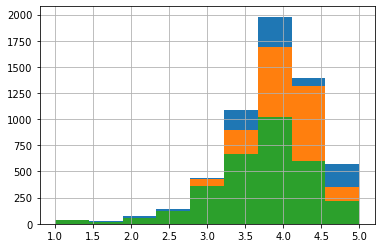

CategoricalIndex(['London', 'Paris', 'Madrid'], categories=['Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Bratislava', 'Brussels', 'Budapest', 'Copenhagen', ...], ordered=False, dtype='category')


In [25]:
# посмотрим на рейтинг топ 10 городов
# развернем, чтобы было удобнее анализировать и сопоставлять с ranking
for x in (df['City'].value_counts())[0:3].index:
    (df['Rating'][df['City'] == x]).hist(bins=9)
plt.show()
# видно, что распределение в каждом городе очень схоже
print((df['City'].value_counts())[0:3].index)

In [26]:
# попробуем предсказать рейтинг из распределения по городу и ранга в городе
for city in df['City'].unique():
    x1 = df['Rating'][df['City'] == city] # выбираем доступные данные для города
    x1 = x1 * (-1) + 5 # переворачиваем оценку 1..5 в диапазон 4..0
    a, b, c = sps.lognorm.fit(x1) # определяем параметры распределения
    n = df['Ranking'][df['City'] == city].max() # максимальный известный номер в рейтинге
    x2 = sps.lognorm.rvs(a, loc=b, scale=c, size=int(n*1.5)) # генерируем предполагаемое распределение с запасом
    x2 = np.sort(x2)
#     print(np.sort(x2))
    df.loc[df['City'] == city, 'RankRate'] = df['Ranking'][df['City'] == city].apply(lambda x: x2[int(x-1)])
df['RankRate'] = (df['RankRate'] - 5) * (-1) # вернем в диапазон 1..5

In [27]:
# df[['Rating', 'RankRate']]

In [28]:
# добавим признак количества заявленных кухонь
df['nCuisine'] = df['Cuisine'].apply(len)

In [29]:
# добавим среднюю оценку ресторанов по городу
rating_by_city = df[['City', 'Rating']].groupby(by='City').agg(['min', 'mean', 'std', 'max'])
rating_by_city = rating_by_city['Rating']
mean_rating_values = {rating_by_city.index[i]: rating_by_city['mean'].values[i] for i in range(rating_by_city.shape[0])}
df['MeanCityRating'] = df['City'].replace(to_replace=mean_rating_values)

In [30]:
# добавим среднее отклонение рейтинга по городу
std_rating_values = {rating_by_city.index[i]: rating_by_city['std'].values[i] for i in range(rating_by_city.shape[0])}
df['StdCityRating'] = df['City'].replace(to_replace=std_rating_values)

In [31]:
# нормируем ранг ресторана в городе из диапазона 1..max в 0..1
# первый номер будет 0,9999 и так далее
ranking_by_city = df[['City', 'Ranking']].groupby(by='City').agg(['describe'])
ranking_by_city = ranking_by_city['Ranking']['describe']
# максимальный номер в городе
max_ranking_values = {ranking_by_city.index[i]: ranking_by_city['max'].values[i] for i in range(ranking_by_city.shape[0])}
df['MaxRank'] = df['City'].replace(to_replace=max_ranking_values)
df['RelRank'] = (df['MaxRank'] - df['Ranking']) / df['MaxRank']
# df.drop(columns='MaxRank', inplace=True)

In [32]:
ploc = mean_rating_values['Paris']
pscale = std_rating_values['Paris']
pmax = int(max_ranking_values['Paris'])
sample = sps.norm(loc=ploc, scale=pscale).rvs(size=pmax)
sample.sort()
sample[10000]

4.3083518503055

In [33]:
max_ranking_values

{'Amsterdam': 3249.0,
 'Athens': 1787.0,
 'Barcelona': 7796.0,
 'Berlin': 6372.0,
 'Bratislava': 889.0,
 'Brussels': 3004.0,
 'Budapest': 2438.0,
 'Copenhagen': 1964.0,
 'Dublin': 1960.0,
 'Edinburgh': 1766.0,
 'Geneva': 1413.0,
 'Hamburg': 2736.0,
 'Helsinki': 1141.0,
 'Krakow': 1244.0,
 'Lisbon': 3717.0,
 'Ljubljana': 468.0,
 'London': 16444.0,
 'Luxembourg': 621.0,
 'Lyon': 2666.0,
 'Madrid': 8809.0,
 'Milan': 6275.0,
 'Munich': 2763.0,
 'Oporto': 1484.0,
 'Oslo': 1137.0,
 'Paris': 13986.0,
 'Prague': 4188.0,
 'Rome': 5946.0,
 'Stockholm': 2464.0,
 'Vienna': 3444.0,
 'Warsaw': 2141.0,
 'Zurich': 1590.0}

In [34]:
# признак того, сколько дней прошло оносительно последнего отзыва
max_date = df['ReviewsDate'].explode().max()
min_date = df['ReviewsDate'].explode().min()
# отметим пропуски отдельно
df['ReviewsDate_WasNA'] = df['ReviewsDate'].apply(lambda x: 1 if x else 0).astype('uint8')
# все пропуски отметим, как самые старые
df['nDaysReviews'] = df['ReviewsDate'].apply(lambda x: (max_date - max(x)).days if x else (max_date - min_date).days)

In [35]:
# категориальный City в dummy
# df = pd.get_dummies(df, columns=['City'], dummy_na=True)

In [36]:
# Cuisine в лоб не получится - слишком много, слишком разное, да ещё и список
# составим разные признаки
VeganLabel = ['Vegetarian Friendly', 'Vegan Options']
df['isVegan'] = df['Cuisine'].apply(lambda x: any(e in x for e in VeganLabel)).astype('uint8')
HealthyLabel = ['Healthy', 'Gluten Free Options']
df['isHealthy'] = df['Cuisine'].apply(lambda x: any(e in x for e in HealthyLabel)).astype('uint8')
FastLabel = ['Fast Food', 'Cafe', 'Soups', 'Street Food', 'Diner']
df['isFast'] = df['Cuisine'].apply(lambda x: any(e in x for e in FastLabel)).astype('uint8')
AlcoLabel = ['Bar', 'Pub', 'Wine Bar', 'Brew Pub', 'Gastropub']
df['isAlco'] = df['Cuisine'].apply(lambda x: any(e in x for e in AlcoLabel)).astype('uint8')
# MeatLabel = ['Steakhouse', 'Barbecue', 'Grill']
# df['isMeat'] = df['Cuisine'].apply(lambda x: any(e in x for e in MeatLabel)).astype('uint8')
# SushiLabel = ['Sushi']
# df['isSushi'] = df['Cuisine'].apply(lambda x: any(e in x for e in SushiLabel)).astype('uint8')
# PizzaLabel = ['Pizza']
# df['isPizza'] = df['Cuisine'].apply(lambda x: any(e in x for e in PizzaLabel)).astype('uint8')
# ModernLabel = ['Fusion', 'Contemporary']
# df['isModern'] = df['Cuisine'].apply(lambda x: any(e in x for e in ModernLabel)).astype('uint8')
# HalalLabel = ['Halal']
# df['isHalal'] = df['Cuisine'].apply(lambda x: any(e in x for e in HalalLabel)).astype('uint8')
# KosherLabel = ['Kosher']
# df['isKosher'] = df['Cuisine'].apply(lambda x: any(e in x for e in KosherLabel)).astype('uint8')

In [37]:
df.head().T

,0,1,2,3,4
City,Paris,Stockholm,London,Berlin,Munich
Cuisine,"[European, French, International]",[Unknown],"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",[Unknown],"[German, Central European, Vegetarian Friendly]"
Ranking,5570.0,1537.0,353.0,3458.0,621.0
Rating,3.5,4.0,4.5,5.0,4.0
Price,2.0,1.943182,3.0,1.754799,2.0
nReviews,194,10,688,3,84
Price_WasNA,0,1,0,1,0
ReviewsText,"[Good food at your doorstep, A good hotel rest...","[Unique cuisine, Delicious Nepalese food]","[Catch up with friends, Not exceptional]",[],"[Best place to try a Bavarian food, Nice build..."
ReviewsDate,"[2017-12-31 00:00:00, 2017-11-20 00:00:00]","[2017-07-06 00:00:00, 2016-06-19 00:00:00]","[2018-01-08 00:00:00, 2018-01-06 00:00:00]",[],"[2017-11-18 00:00:00, 2017-02-19 00:00:00]"
nReviews_WasNA,0,0,0,0,0


# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   City               40000 non-null  category
 1   Cuisine            40000 non-null  object  
 2   Ranking            40000 non-null  float64 
 3   Rating             40000 non-null  float64 
 4   Price              40000 non-null  float64 
 5   nReviews           40000 non-null  uint32  
 6   Price_WasNA        40000 non-null  uint8   
 7   ReviewsText        40000 non-null  object  
 8   ReviewsDate        40000 non-null  object  
 9   nReviews_WasNA     40000 non-null  uint8   
 10  RankRate           40000 non-null  float64 
 11  nCuisine           40000 non-null  int64   
 12  MeanCityRating     40000 non-null  float64 
 13  StdCityRating      40000 non-null  float64 
 14  MaxRank            40000 non-null  float64 
 15  RelRank            40000 non-null  float64 
 16  Revi

In [39]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.select_dtypes(include='number').drop(['Rating', 'RelRank', 'Ranking'], axis=1)
print(X.columns)
y = df['Rating']

Index(['Price', 'nReviews', 'Price_WasNA', 'nReviews_WasNA', 'RankRate',
       'nCuisine', 'MeanCityRating', 'StdCityRating', 'MaxRank',
       'ReviewsDate_WasNA', 'nDaysReviews', 'isVegan', 'isHealthy', 'isFast',
       'isAlco'],
      dtype='object')


In [40]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [41]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2021)

# Создаём, обучаем и тестируем модель

In [42]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [43]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [44]:
# постпроцессинг
# округляем до 0,5, т.к. на сайте рейтинг с такой точностью
y_pred = np.around(y_pred * 2) / 2

In [45]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.17765


<AxesSubplot:>

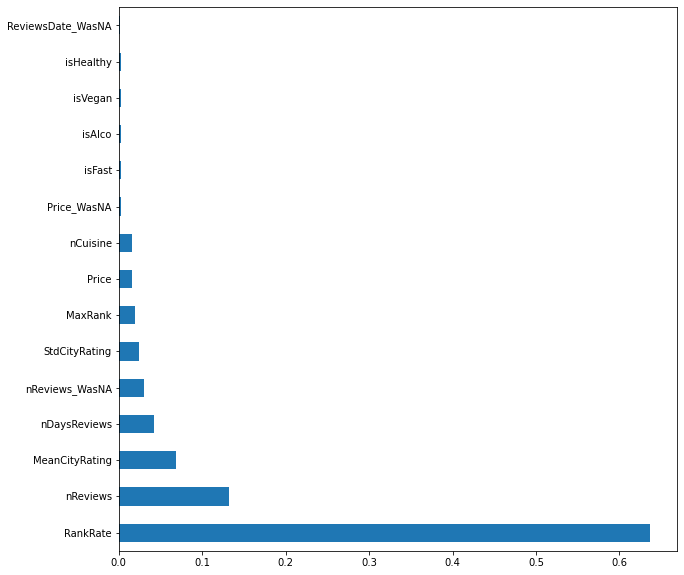

In [46]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')